**From GT coding session tues:**

PCA = principal component analysis - look at the udemy course for this stuff... can compare the similar compounds to the known binders to the random compounds and see potential clustering. Can I split by affinity in the large dataset as well?

# Docking Validation

This notebook shows the validation of docking results from docking.ipynb. 

Test smiles lists = ChemBL-drug-small molecules as smallmols, compounds similar in structure and substructure to CHO (PabB substrate), aminodeoxyCHO (PabB product), and truncated aminodeoxyCHO (truncated PabB product; as allsim), abyssomicin C and CHO as binders, and 100 random compounds as random.

Plan - each of these datasets will be subjected to docking as per docking.ipynb and a .csv file with affinities, molecule ID's, smiles and all 200 RDkit molecular descriptors generated. This .csv file will then be used in this notbeook. Descriptors will be tested for their correlation with minimizedAffinity (docking score). Specific descriptors of interest include' molecular weigh, number of heteroatoms, and number of rotatable bonds. Scoring function (vinardo or vina) can also be tested on a subset of each dataset (cannot run whole datasets twice due to time constraints), to ascertain which scoring funciton is the least biased. Original distributions in terms of MolWT, HetAtms etc will also be displayed and datasets may be weighted.

In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdCoordGen
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

%matplotlib inline

DATAPATH = "../data"
RESULTSPATH = "../results"
SOURCEPATH = "../src"


### ChemBL smallmols

ChemBL contains a database of known drugs. These were filtered on ChemBL for 'Small Molecules, MW > 100' and entered into the docking pathway.

Information to extract = start length, merged.sdf length, distribution MW, dist RotBonds, dist hetatms, correlation Mw-docking, corr RotBonds-docking, corr hetatms-docking.

Rerun 100 compounds with vina scoring and do the same as above, compare vinardo to vina.

In [2]:
df_smallmols_alldesc = pd.read_csv(os.path.join(RESULTSPATH, "outputs", "smiles_200descriptors.csv"))

df_smallmols_alldesc.head()

,minimizedAffinity,ID,ST_SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-5.46148,4,C[C@@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O...,16.373716,-4.214838,16.373716,0.240165,0.874740,361.373,341.213,...,0,0,0,0,0,0,0,0,0,0
1,-5.93024,8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,15.976568,-3.952448,15.976568,0.102712,0.893230,331.347,313.203,...,0,0,0,0,0,0,0,0,0,0
2,-5.66769,9,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,15.880938,-3.964746,15.880938,0.331878,0.891026,319.336,301.192,...,0,0,0,0,0,0,0,0,0,0
3,-6.49326,17,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,11.810604,-5.042809,11.810604,0.817698,0.815212,305.164,299.116,...,0,2,0,0,0,0,0,0,0,0
4,-5.89199,26,CCN1CCC[C@H]1CNC(=O)c1cc(S(N)(=O)=O)ccc1OC,13.668661,-5.626770,13.668661,1.020795,0.786943,341.433,318.249,...,0,1,0,0,0,0,0,0,0,0


Text(0, 0.5, '')

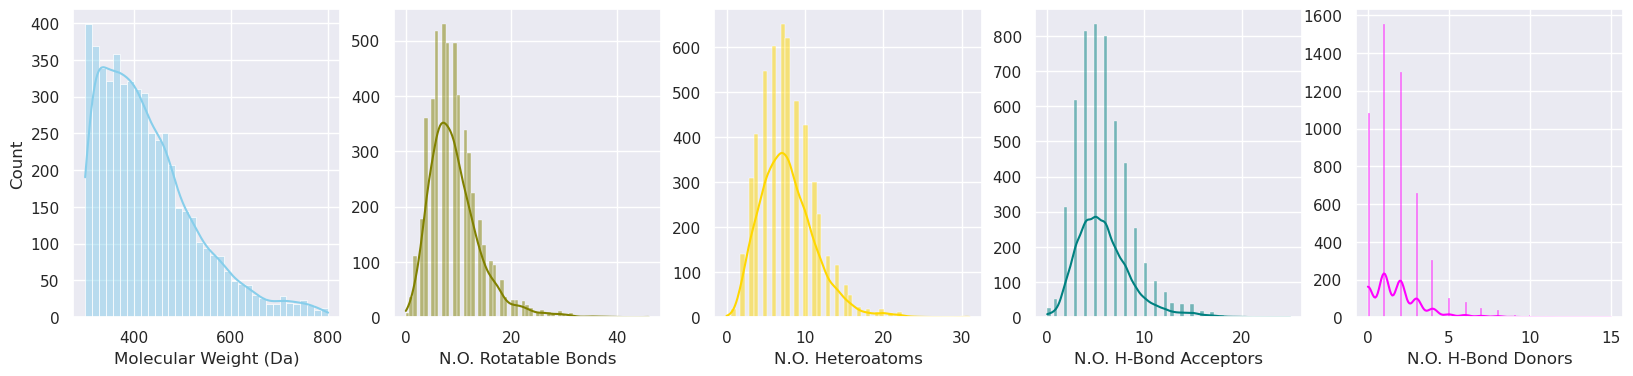

In [56]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

ax1 = sns.histplot(data=df_smallmols_alldesc, x="MolWt", kde=True, color="skyblue", ax=axs[0])
ax1.set_xlabel("Molecular Weight (Da)")
ax1.set_ylabel("Count")

ax2 = sns.histplot(data=df_smallmols_alldesc, x="NumRotatableBonds", kde=True, color="olive", ax=axs[1])
ax2.set_xlabel("N.O. Rotatable Bonds")
ax2.set_ylabel("")

ax3 = sns.histplot(data=df_smallmols_alldesc, x="NumHeteroatoms", kde=True, color="gold", ax=axs[2])
ax3.set_xlabel("N.O. Heteroatoms")
ax3.set_ylabel("")

ax4 = sns.histplot(data=df_smallmols_alldesc, x="NumHAcceptors", kde=True, color="teal", ax=axs[3])
ax4.set_xlabel("N.O. H-Bond Acceptors")
ax4.set_ylabel("")

ax5 = sns.histplot(data=df_smallmols_alldesc, x="NumHDonors", kde=True, color="magenta", ax=axs[4])
ax5.set_xlabel("N.O. H-Bond Donors")
ax5.set_ylabel("")


Text(0, 0.5, '')

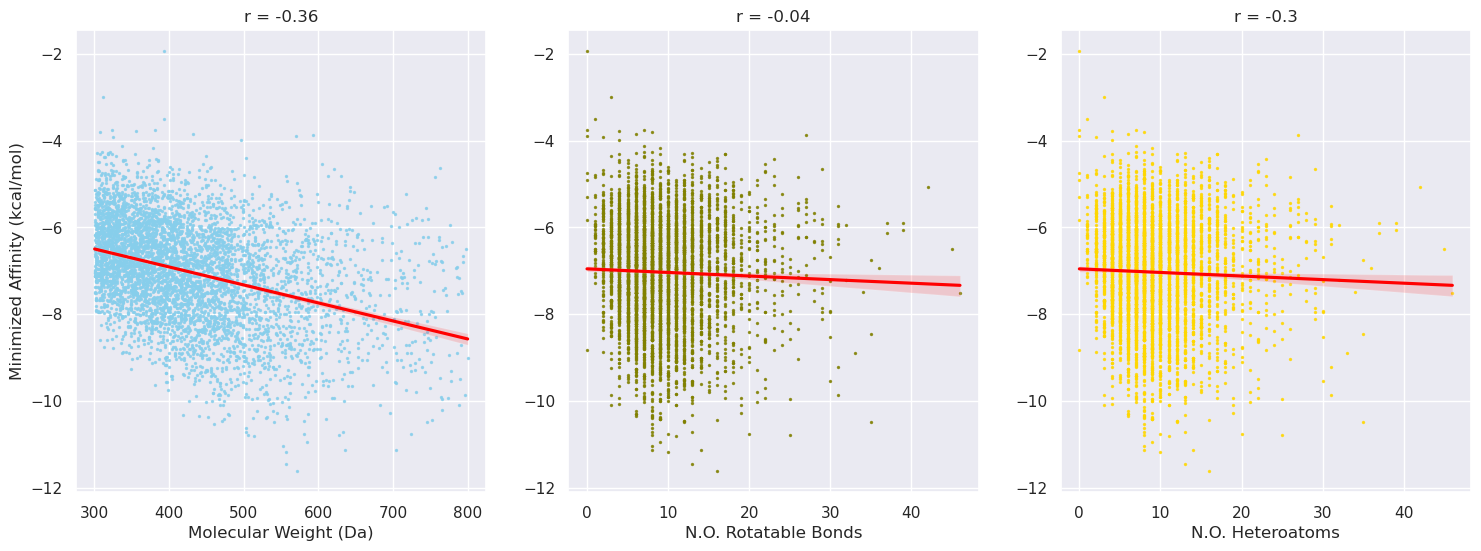

In [53]:
# Correlation between minimizedAffinity and descriptors.

sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax1 = sns.regplot(x="MolWt", y="minimizedAffinity", data=df_smallmols_alldesc,
                  scatter_kws={"color": "skyblue", "s": 2}, line_kws={"color": "red"}, ax=axs[0])
r1=-0.36
ax1.set_title("r = {}".format(r1))
ax1.set_xlabel("Molecular Weight (Da)")
ax1.set_ylabel("Minimized Affinity (kcal/mol)")

ax2 = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=df_smallmols_alldesc,
                  scatter_kws={"color": "olive", "s": 2}, line_kws={"color": "red"}, ax=axs[1])
r2 = -0.04
ax2.set_title("r = {}".format(r2))
ax2.set_xlabel("N.O. Rotatable Bonds")
ax2.set_ylabel("")

ax3 = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=df_smallmols_alldesc,
                  scatter_kws={"color": "gold", "s": 2}, line_kws={"color": "red"}, ax=axs[2])
r3 = -0.30
ax3.set_title("r = {}".format(r3))
ax3.set_xlabel("N.O. Heteroatoms")
ax3.set_ylabel("")


In [20]:
stats.pearsonr(df_smallmols_alldesc['MolWt'], df_smallmols_alldesc['minimizedAffinity'])

PearsonRResult(statistic=-0.36016384299503784, pvalue=3.034055538933042e-159)

Text(0, 0.5, 'Minimized Affinity (kcal/mol)')

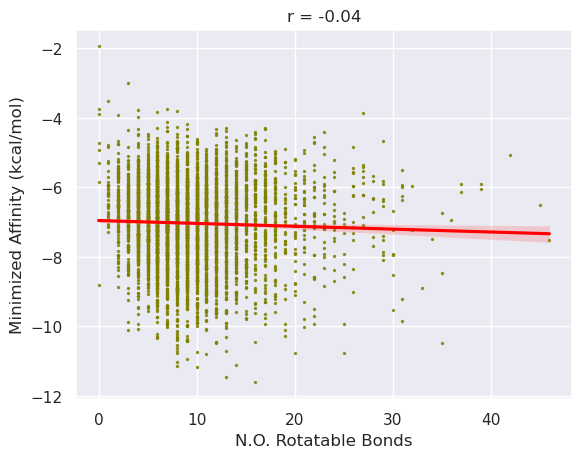

In [13]:
ax = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=df_smallmols_alldesc,
                  scatter_kws={"color": "olive", "s": 2}, line_kws={"color": "red"})
r = -0.04
ax.set_title("r = {}".format(r))
ax.set_xlabel("N.O. Rotatable Bonds")
ax.set_ylabel("Minimized Affinity (kcal/mol)")

In [7]:
stats.pearsonr(df_smallmols_alldesc['NumRotatableBonds'], df_smallmols_alldesc['minimizedAffinity'])

PearsonRResult(statistic=-0.035735587504014225, pvalue=0.00991956894050882)

Text(0, 0.5, 'Minimized Affinity (kcal/mol)')

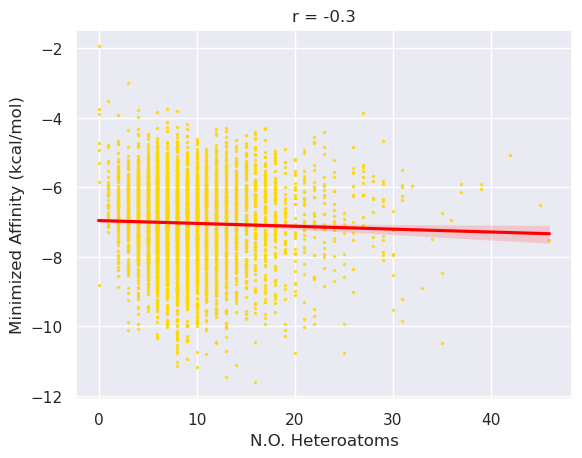

In [14]:
ax = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=df_smallmols_alldesc,
                  scatter_kws={"color": "gold", "s": 2}, line_kws={"color": "red"})
r = -0.30
ax.set_title("r = {}".format(r))
ax.set_xlabel("N.O. Heteroatoms")
ax.set_ylabel("Minimized Affinity (kcal/mol)")

In [9]:
stats.pearsonr(df_smallmols_alldesc['NumHeteroatoms'], df_smallmols_alldesc['minimizedAffinity'])

PearsonRResult(statistic=-0.2958545157104485, pvalue=1.1500617795121049e-105)

In [10]:
cols = [0, 8, 116, 117, 119, 118] # can alter here depending on how you want to filter
df_matrix = df_smallmols_alldesc[df_smallmols_alldesc.columns[cols]]
cormat = df_matrix.corr()
round(cormat,2)


,minimizedAffinity,MolWt,NumHAcceptors,NumHDonors,NumRotatableBonds,NumHeteroatoms
minimizedAffinity,1.00,-0.36,-0.25,-0.17,-0.04,-0.30
MolWt,-0.36,1.00,0.56,0.29,0.52,0.64
NumHAcceptors,-0.25,0.56,1.00,0.56,0.39,0.85
NumHDonors,-0.17,0.29,0.56,1.00,0.31,0.55
NumRotatableBonds,-0.04,0.52,0.39,0.31,1.00,0.26
NumHeteroatoms,-0.30,0.64,0.85,0.55,0.26,1.00


In [11]:
# Principal component analysis

df = pd.read_csv(os.path.join(RESULTSPATH, "outputs", "smiles_200descriptors.csv"))
df.drop(columns = ["ST_SMILES", "ID"], inplace=True)

scaler = StandardScaler()
scaler.fit(df) 
scaled_data = scaler.transform(df) 
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

Text(0, 0.5, 'Second Principal Component')

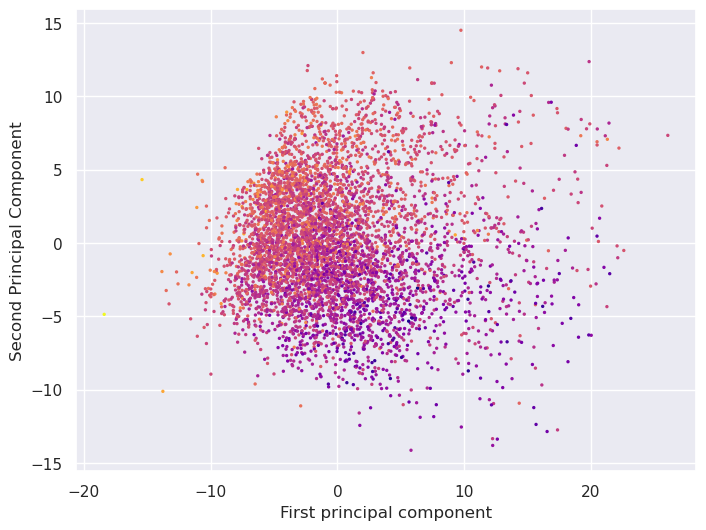

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], s=2, marker='o', c=df['minimizedAffinity'], cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component') 

### ChemBL smallmols - vina scoring

Smallmols were run as above, this time with vina as the scoring function in smina. The re-standardisation step in analysis was removed, therefore these smiles are not necessarily canonical. 

In [61]:
vina_smallmols = pd.read_csv(os.path.join(RESULTSPATH, "outputs", "smallmols_vina__smiles_200descriptors.csv"))

vina_smallmols.shape

(5206, 211)

<Axes: xlabel='NumHeteroatoms', ylabel='Count'>

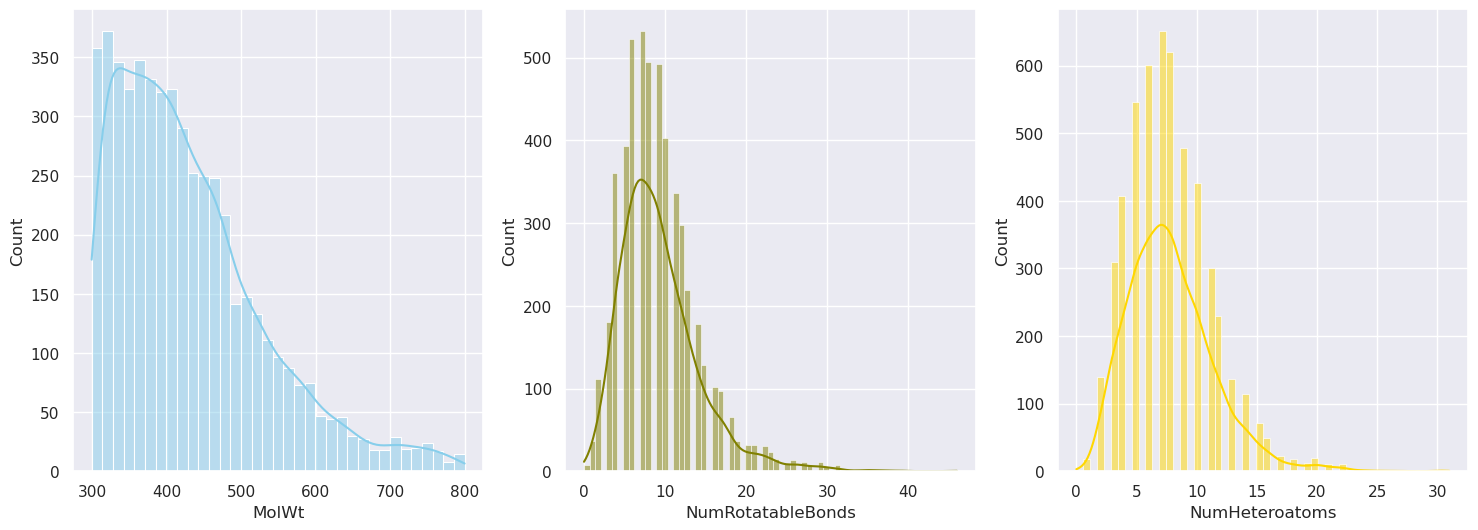

In [14]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=vina_smallmols, x="MolWt", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=vina_smallmols, x="NumRotatableBonds", kde=True, color="olive", ax=axs[1])
sns.histplot(data=vina_smallmols, x="NumHeteroatoms", kde=True, color="gold", ax=axs[2])

<Axes: xlabel='NumHDonors', ylabel='Count'>

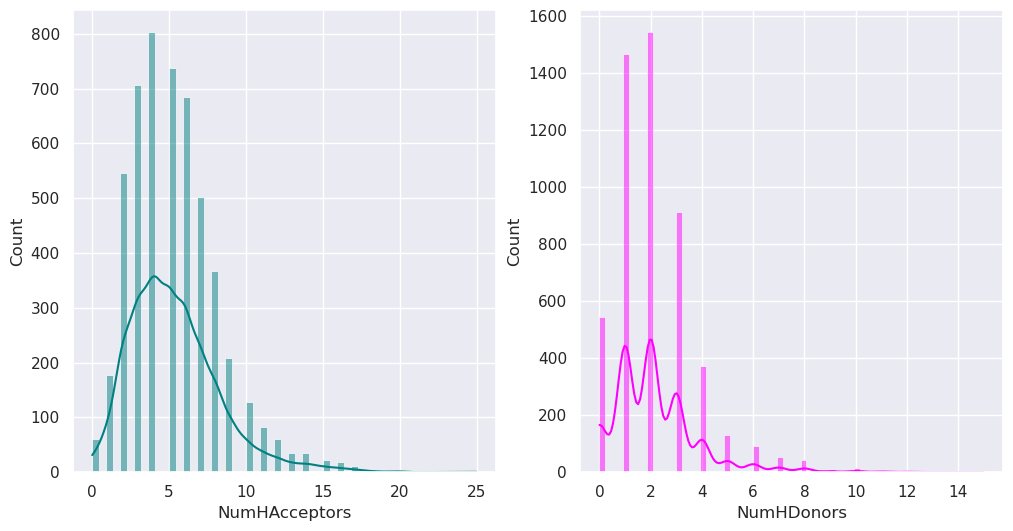

In [15]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=vina_smallmols, x="NumHAcceptors", kde=True, color="teal", ax=axs[0])
sns.histplot(data=vina_smallmols, x="NumHDonors", kde=True, color="magenta", ax=axs[1])

Text(0, 0.5, '')

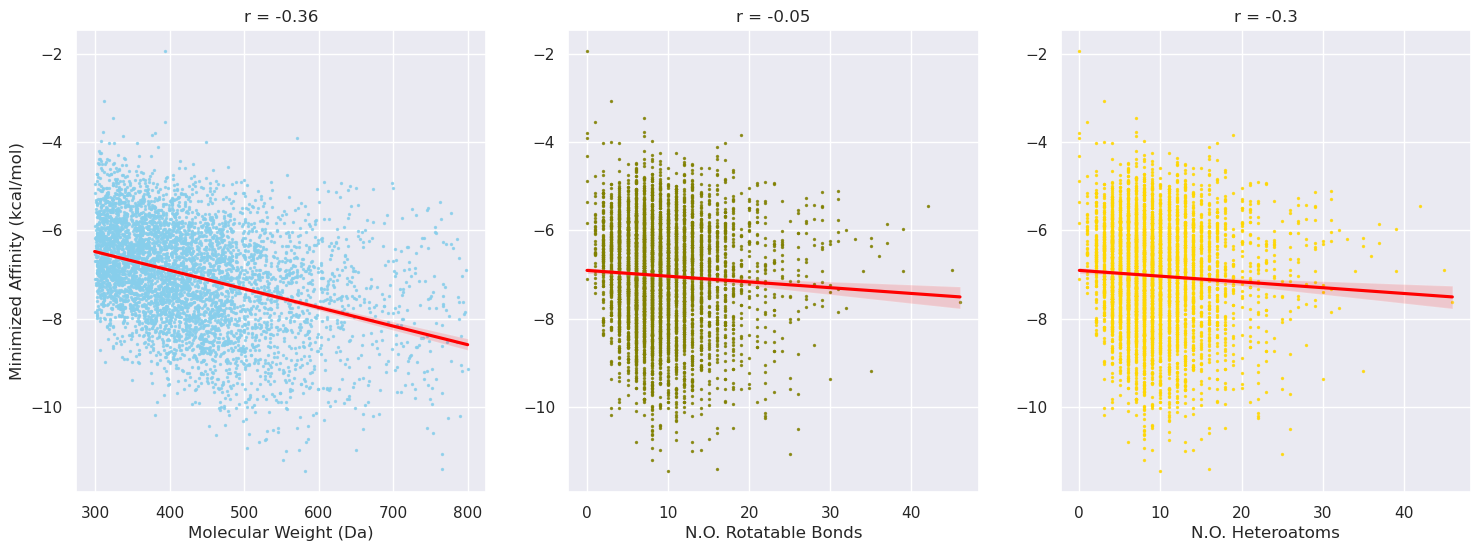

In [58]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax1 = sns.regplot(x="MolWt", y="minimizedAffinity", data=vina_smallmols,
                  scatter_kws={"color": "skyblue", "s": 2}, line_kws={"color": "red"}, ax=axs[0])
r1=-0.36
ax1.set_title("r = {}".format(r1))
ax1.set_xlabel("Molecular Weight (Da)")
ax1.set_ylabel("Minimized Affinity (kcal/mol)")

ax2 = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=vina_smallmols,
                  scatter_kws={"color": "olive", "s": 2}, line_kws={"color": "red"}, ax=axs[1])
r2 = -0.05
ax2.set_title("r = {}".format(r2))
ax2.set_xlabel("N.O. Rotatable Bonds")
ax2.set_ylabel("")

ax3 = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=vina_smallmols,
                  scatter_kws={"color": "gold", "s": 2}, line_kws={"color": "red"}, ax=axs[2])
r3 = -0.30
ax3.set_title("r = {}".format(r3))
ax3.set_xlabel("N.O. Heteroatoms")
ax3.set_ylabel("")


Text(0, 0.5, 'Minimized Affinity (kcal/mol)')

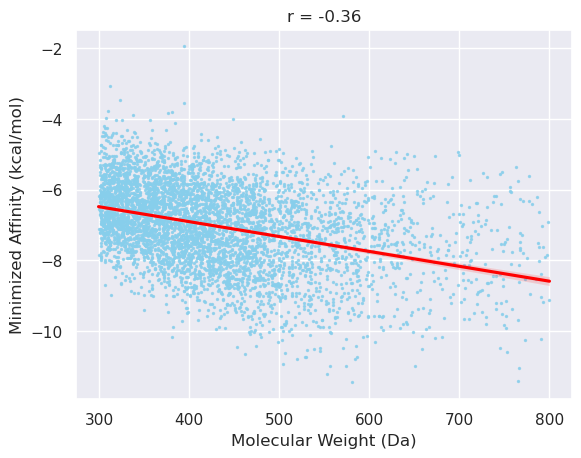

In [22]:
ax1 = sns.regplot(x="MolWt", y="minimizedAffinity", data=vina_smallmols,
                  scatter_kws={"color": "skyblue", "s": 2}, line_kws={"color": "red"})
r = -0.36
ax1.set_title("r = {}".format(r))
ax1.set_xlabel("Molecular Weight (Da)")
ax1.set_ylabel("Minimized Affinity (kcal/mol)")

In [17]:
stats.pearsonr(vina_smallmols['MolWt'], vina_smallmols['minimizedAffinity'])

PearsonRResult(statistic=-0.3646405187701681, pvalue=1.8015230540743088e-163)

Text(0, 0.5, 'Minimized Affinity (kcal/mol)')

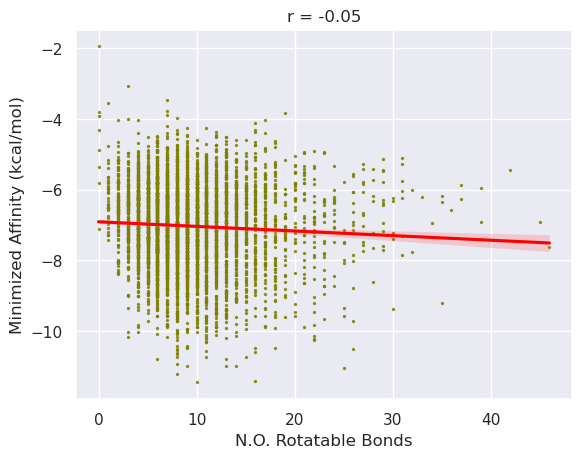

In [21]:
ax = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=vina_smallmols,
                  scatter_kws={"color": "olive", "s": 2}, line_kws={"color": "red"})
r = -0.05
ax.set_title("r = {}".format(r))
ax.set_xlabel("N.O. Rotatable Bonds")
ax.set_ylabel("Minimized Affinity (kcal/mol)")

In [62]:
stats.pearsonr(vina_smallmols['NumRotatableBonds'], vina_smallmols['minimizedAffinity'])

PearsonRResult(statistic=-0.056174552659380546, pvalue=5.0055028259881944e-05)

Text(0, 0.5, 'Minimized Affinity (kcal/mol)')

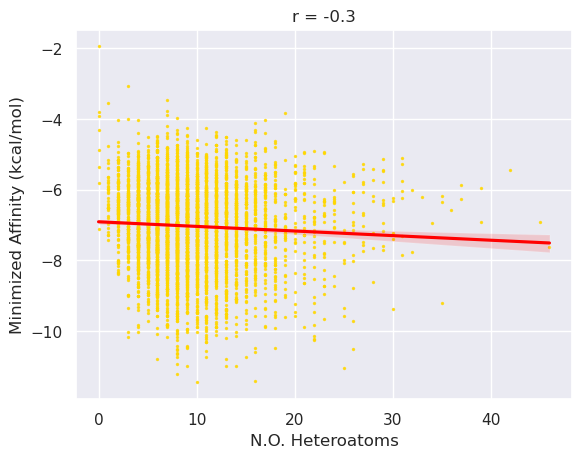

In [20]:
ax = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=vina_smallmols,
                  scatter_kws={"color": "gold", "s": 2}, line_kws={"color": "red"})
r = -0.30
ax.set_title("r = {}".format(r))
ax.set_xlabel("N.O. Heteroatoms")
ax.set_ylabel("Minimized Affinity (kcal/mol)")

In [21]:
stats.pearsonr(vina_smallmols['NumHeteroatoms'], vina_smallmols['minimizedAffinity'])

PearsonRResult(statistic=-0.29803383764700897, pvalue=2.8414271765181e-107)

In [22]:
cols = [0, 8, 116, 117, 119, 118] # can alter here depending on how you want to filter
df_matrix3 = vina_smallmols[vina_smallmols.columns[cols]]
cormat = df_matrix3.corr()
round(cormat,2)

,minimizedAffinity,MolWt,NumHAcceptors,NumHDonors,NumRotatableBonds,NumHeteroatoms
minimizedAffinity,1.00,-0.36,-0.27,-0.15,-0.06,-0.30
MolWt,-0.36,1.00,0.53,0.31,0.52,0.64
NumHAcceptors,-0.27,0.53,1.00,0.44,0.36,0.84
NumHDonors,-0.15,0.31,0.44,1.00,0.31,0.51
NumRotatableBonds,-0.06,0.52,0.36,0.31,1.00,0.26
NumHeteroatoms,-0.30,0.64,0.84,0.51,0.26,1.00


In [23]:
df = pd.read_csv(os.path.join(RESULTSPATH, "outputs", "smallmols_vina__smiles_200descriptors.csv"))
df.drop(columns = ["SMILES", "ID"], inplace=True)

scaler = StandardScaler()
scaler.fit(df) 
scaled_data = scaler.transform(df) 
pca = PCA(n_components=2)
pca.fit(scaled_data)
y_pca = pca.transform(scaled_data)

Text(0, 0.5, 'Second Principal Component')

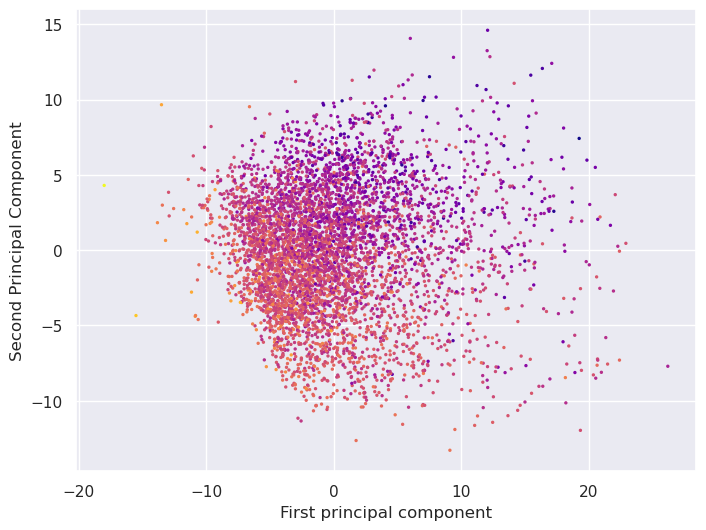

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(y_pca[:,0],y_pca[:,1], s=2, marker='o', c=df['minimizedAffinity'], cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component') 

### Similarmols

ChemBL and PubChem similarity searches were used for the generation of similar molecules. ChemBL was searched at 40 % similarity and 40 % substructure similarity for the compounds below. These compounds were also used in the PubChem search (Fingerprint Tanimoto-based 2-dimensional similarity search). Once all datasets were obtained the .csv files were merged and duplicates removed. Ersilia also have models to search for the 100 most similar compounds in ChemBL and PubChem but this was not used for the validation step.

tADC substructure search on PuBMed retruend .csv file missing information, therefore the PubChem 3D similarity search was performed and the resulting 591 compounds downloaded.

The docking performed for the validation of this dataset involved filtering compounds between 150-300 da, to keep them in the range of CHO/ADC. tADC MW = 155, so 150 cutoff. A total of 576 compounds were docked.

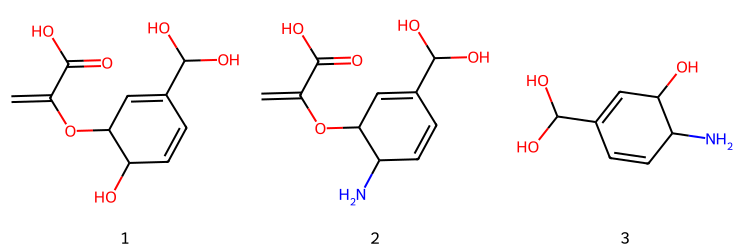

In [72]:
CHO = Chem.MolFromSmiles('C=C(OC1C=C(C(O)O)C=CC1O)C(=O)O')
ADC = Chem.MolFromSmiles('C=C(OC1C=C(C(O)O)C=CC1N)C(=O)O')
tADC = Chem.MolFromSmiles('NC1C=CC(C(O)O)=CC1O')

Draw.MolsToGridImage((CHO,ADC,tADC), subImgSize=(250,250), legends='123')


Information to extract = start length, merged.sdf length, distribution MW, dist RotBonds, dist hetatms, correlation Mw-docking, corr RotBonds-docking, corr hetatms-docking.

Rerun 100 compounds with vina scoring and do the same as above, compare vinardo to vina.

In [19]:
all_sim_data = pd.read_csv(os.path.join(RESULTSPATH, "validation_outputs", "allsimilar_smiles_200descriptors.csv"))

all_sim_data.head()

,minimizedAffinity,ID,ST_SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-5.54176,1207610,C=C(O[C@@H]1C=CC=C[C@H]1O)C(=O)O,11.317847,-3.231806,11.317847,0.963618,0.491116,182.175,172.095,...,0,0,0,0,0,0,0,0,0,0
1,-5.56923,419714,C=C(O[C@@H]1C=CC=C[C@H]1O)C(=O)O,11.317847,-3.231806,11.317847,0.963618,0.491116,182.175,172.095,...,0,0,0,0,0,0,0,0,0,0
2,-6.34214,1160745,C=C(O[C@@H]1C=C(C(=O)O)C=C[C@H]1O)C(=O)O,11.609468,-3.447639,11.609468,1.171271,0.456894,226.184,216.104,...,0,0,0,0,0,0,0,0,0,0
3,-5.86645,367558,C=C(O[C@@H]1C=C(C(=O)O)CC[C@@H]1O)C(=O)O,11.787732,-3.824010,11.787732,1.552992,0.466580,228.200,216.104,...,0,0,0,0,0,0,0,0,0,0
4,-5.06975,369433,C=C(O[C@@H]1C=C(C(=O)O)[C@H](O)[C@@H](O)[C@H]1...,11.985771,-3.947969,11.985771,1.592178,0.290291,260.198,248.102,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, '')

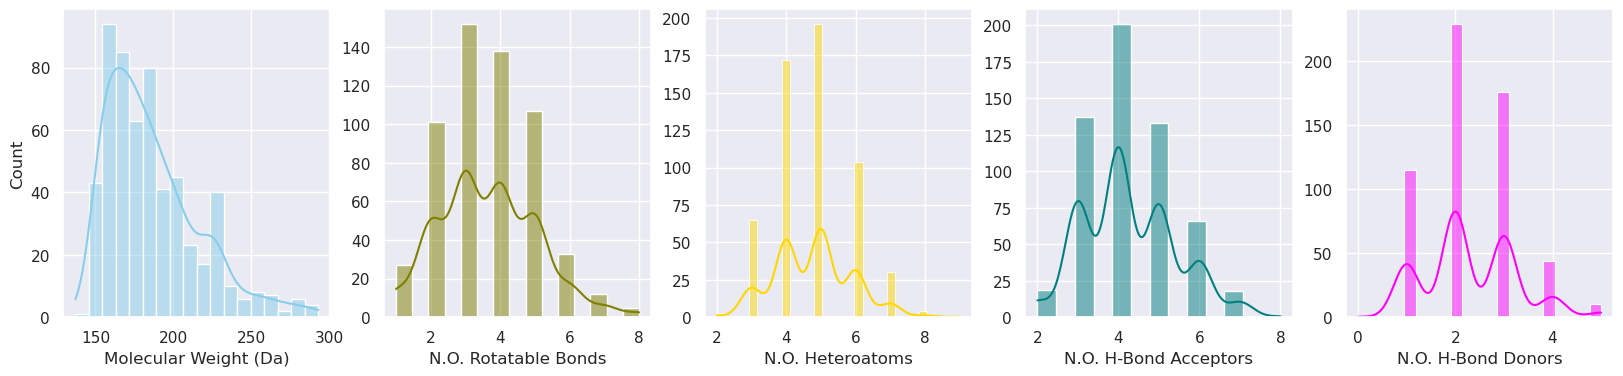

In [73]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

ax1 = sns.histplot(data=all_sim_data, x="MolWt", kde=True, color="skyblue", ax=axs[0])
ax1.set_xlabel("Molecular Weight (Da)")
ax1.set_ylabel("Count")

ax2 = sns.histplot(data=all_sim_data, x="NumRotatableBonds", kde=True, color="olive", ax=axs[1])
ax2.set_xlabel("N.O. Rotatable Bonds")
ax2.set_ylabel("")

ax3 = sns.histplot(data=all_sim_data, x="NumHeteroatoms", kde=True, color="gold", ax=axs[2])
ax3.set_xlabel("N.O. Heteroatoms")
ax3.set_ylabel("")

ax4 = sns.histplot(data=all_sim_data, x="NumHAcceptors", kde=True, color="teal", ax=axs[3])
ax4.set_xlabel("N.O. H-Bond Acceptors")
ax4.set_ylabel("")

ax5 = sns.histplot(data=all_sim_data, x="NumHDonors", kde=True, color="magenta", ax=axs[4])
ax5.set_xlabel("N.O. H-Bond Donors")
ax5.set_ylabel("")


Text(0, 0.5, '')

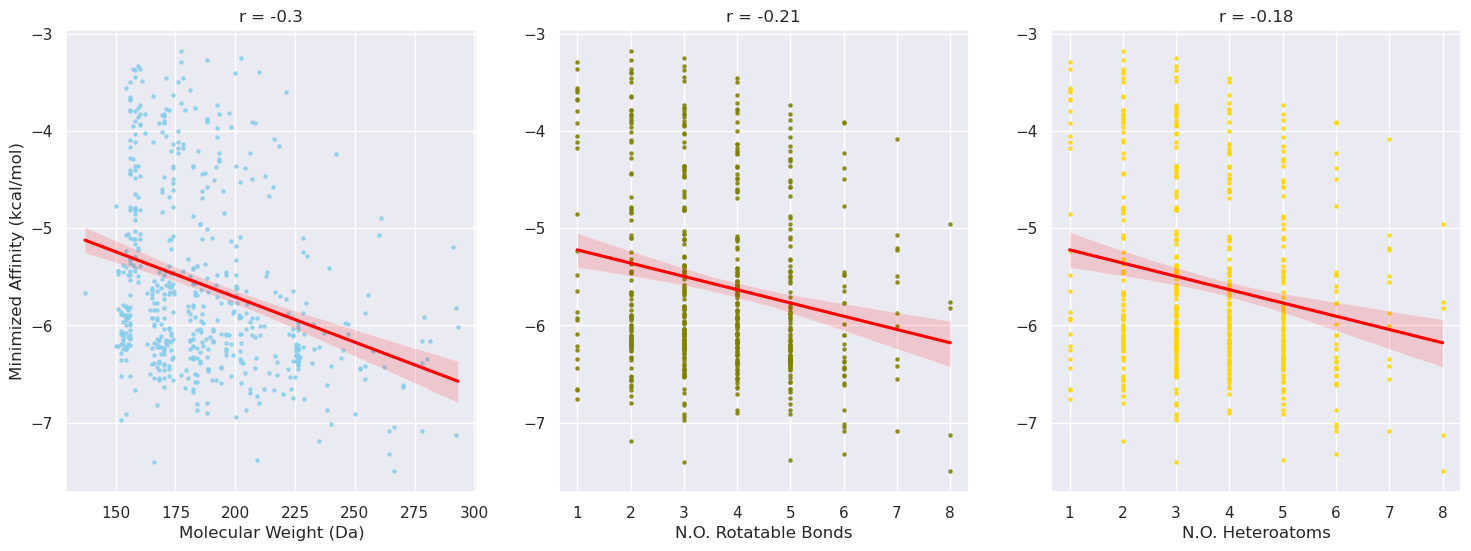

In [77]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax1 = sns.regplot(x="MolWt", y="minimizedAffinity", data=all_sim_data,
                  scatter_kws={"color": "skyblue", "s": 5}, line_kws={"color": "red"}, ax=axs[0])
r1=-0.30
ax1.set_title("r = {}".format(r1))
ax1.set_xlabel("Molecular Weight (Da)")
ax1.set_ylabel("Minimized Affinity (kcal/mol)")

ax2 = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=all_sim_data,
                  scatter_kws={"color": "olive", "s": 5}, line_kws={"color": "red"}, ax=axs[1])
r2 = -0.21
ax2.set_title("r = {}".format(r2))
ax2.set_xlabel("N.O. Rotatable Bonds")
ax2.set_ylabel("")

ax3 = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=all_sim_data,
                  scatter_kws={"color": "gold", "s": 5}, line_kws={"color": "red"}, ax=axs[2])
r3 = -0.18
ax3.set_title("r = {}".format(r3))
ax3.set_xlabel("N.O. Heteroatoms")
ax3.set_ylabel("")

Text(0, 0.5, 'Minimized Affinity (kcal/mol)')

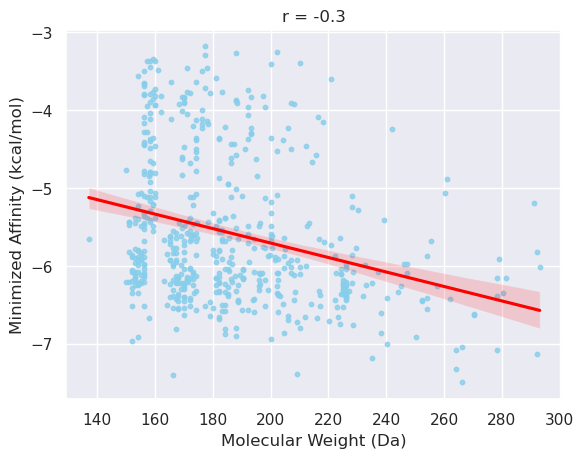

In [24]:
ax1 = sns.regplot(x="MolWt", y="minimizedAffinity", data=all_sim_data,
                  scatter_kws={"color": "skyblue", "s": 10}, line_kws={"color": "red"})
r = -0.30
ax1.set_title("r = {}".format(r))
ax1.set_xlabel("Molecular Weight (Da)")
ax1.set_ylabel("Minimized Affinity (kcal/mol)")


In [29]:
stats.pearsonr(all_sim_data['MolWt'], all_sim_data['minimizedAffinity'])

PearsonRResult(statistic=-0.2972846359251222, pvalue=3.380251348451718e-13)

Text(0, 0.5, 'Minimized Affinity (kcal/mol)')

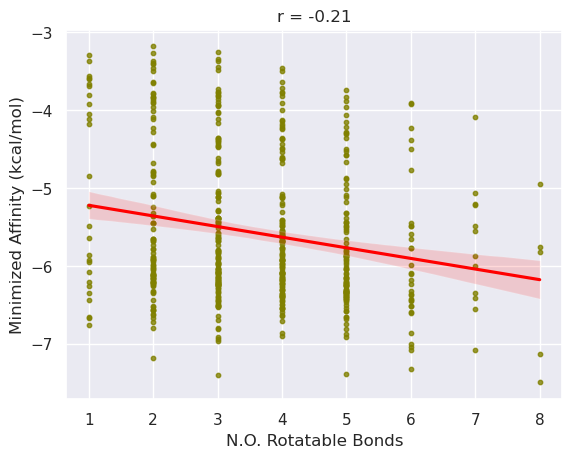

In [29]:
ax = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=all_sim_data,
                  scatter_kws={"color": "olive", "s": 10}, line_kws={"color": "red"})
r = -0.21
ax.set_title("r = {}".format(r))
ax.set_xlabel("N.O. Rotatable Bonds")
ax.set_ylabel("Minimized Affinity (kcal/mol)")

In [31]:
stats.pearsonr(all_sim_data['NumRotatableBonds'], all_sim_data['minimizedAffinity'])

PearsonRResult(statistic=-0.2071706792138091, pvalue=5.402497477115743e-07)

Text(0, 0.5, 'Minimized Affinity (kcal/mol)')

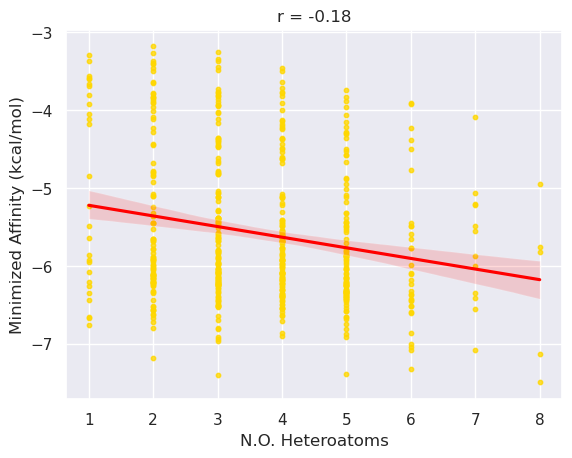

In [30]:
ax = sns.regplot(x="NumRotatableBonds", y="minimizedAffinity", data=all_sim_data,
                  scatter_kws={"color": "gold", "s": 10}, line_kws={"color": "red"})
r = -0.18
ax.set_title("r = {}".format(r))
ax.set_xlabel("N.O. Heteroatoms")
ax.set_ylabel("Minimized Affinity (kcal/mol)")

In [33]:
stats.pearsonr(all_sim_data['NumHeteroatoms'], all_sim_data['minimizedAffinity'])

PearsonRResult(statistic=-0.17750663979453343, pvalue=1.8585356791524855e-05)

In [34]:
cols = [0, 8, 116, 117, 119, 118] # can alter here depending on how you want to filter
df_matrix2 = all_sim_data[all_sim_data.columns[cols]]
cormat = df_matrix2.corr()
round(cormat,2)

,minimizedAffinity,MolWt,NumHAcceptors,NumHDonors,NumRotatableBonds,NumHeteroatoms
minimizedAffinity,1.00,-0.30,-0.01,0.09,-0.21,-0.18
MolWt,-0.30,1.00,0.37,-0.07,0.45,0.60
NumHAcceptors,-0.01,0.37,1.00,0.54,0.50,0.66
NumHDonors,0.09,-0.07,0.54,1.00,0.26,0.30
NumRotatableBonds,-0.21,0.45,0.50,0.26,1.00,0.22
NumHeteroatoms,-0.18,0.60,0.66,0.30,0.22,1.00


In [35]:
df = pd.read_csv(os.path.join(RESULTSPATH, "validation_outputs", "allsimilar_smiles_200descriptors.csv"))
df.drop(columns = ["ST_SMILES", "ID"], inplace=True)

scaler = StandardScaler()
scaler.fit(df) 
scaled_data = scaler.transform(df) 
pca = PCA(n_components=2)
pca.fit(scaled_data)
z_pca = pca.transform(scaled_data)

Text(0, 0.5, 'Second Principal Component')

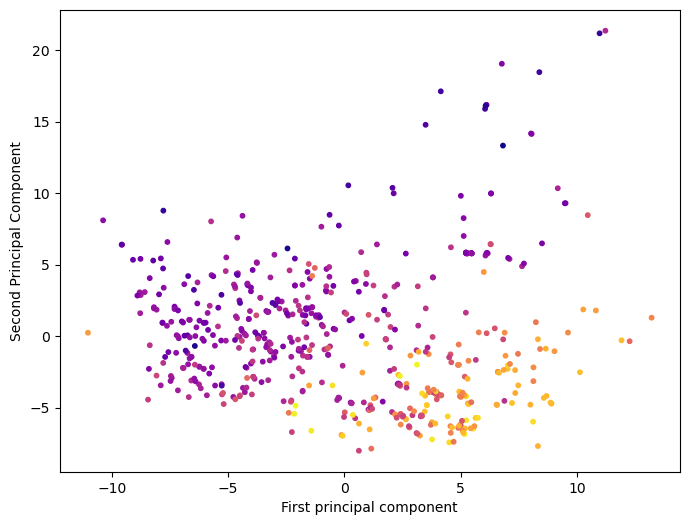

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(z_pca[:,0],z_pca[:,1], s=10, marker='o', c=df['minimizedAffinity'], cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component') 

### Known binders

There are only 3 known binders of PabB - abyssomicin C, CHO and 6-fluoroCHO (which is formed when 6-fluoroshikimate is converted to 6-fluoroCHO). Reports show that anthelminthicin C, torachrysone and MAC173979 also inhibit *p*ABA biosynthesis, specifically by inhibiting between CHO and *p*ABA, but there is no evidence of direct PabB inhibition and they are therefore not included. Interesting side note - MAC173979 has activity against G-ve bacteria, solidifying the approach of *p*ABA biosynthesis inhibtion as a route to effective antimicrobials. It also contains a Michael acceptor, but removal doesn't affect the MIC.


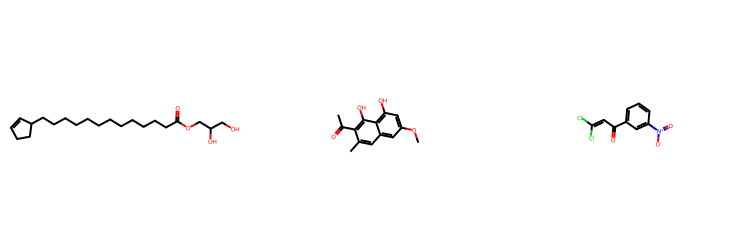

In [4]:
antC = Chem.MolFromSmiles('C1CC(C=C1)CCCCCCCCCCCCC(=O)OCC(CO)O')
tor = Chem.MolFromSmiles('CC1=CC2=CC(=CC(=C2C(=C1C(=O)C)O)O)OC')
MAC = Chem.MolFromSmiles('O=C(C1=CC=CC([N+]([O-])=O)=C1)/C=C(Cl)\Cl')

Draw.MolsToGridImage((antC,tor,MAC), subImgSize=(250,250))

For the docking analysis of known binders, abyssomicin C, CHO and 6-fluroCHO were included (below). These were not subject to filtering by MW.

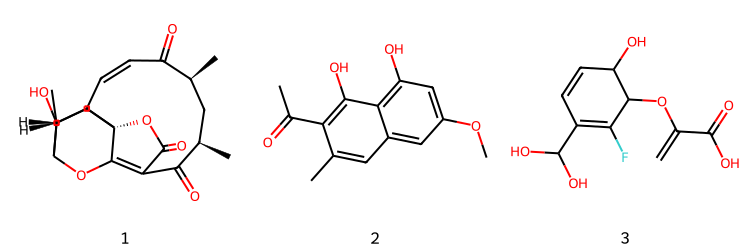

In [78]:
abyC = Chem.MolFromSmiles('C[C@@H]1C[C@H](C)C(=O)/C=C/C2[C@@H](O)C3OC4=C(C(=O)O[C@@]42C[C@H]3C)C1=O')
#rdCoordGen.AddCoords(abyC)
CHO = Chem.MolFromSmiles('CC1=CC2=CC(=CC(=C2C(=C1C(=O)C)O)O)OC')
fCHO = Chem.MolFromSmiles('C=C(OC1C(F)=C(C(O)O)C=CC1O)C(=O)O')

Draw.MolsToGridImage((abyC,CHO,fCHO), subImgSize=(250,250), legends='123')

### Comparisons

PCA comparing smallmols, allsim and binders on one graph. No need to merge datasets. 

In [32]:
df1 = pd.read_csv(os.path.join(RESULTSPATH, "outputs", "smiles_200descriptors.csv"))
df1.drop(columns = ["ST_SMILES", "ID"], inplace=True)

scaler = StandardScaler()
scaler.fit(df1) 
scaled_data = scaler.transform(df1) 
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

In [33]:
df2 = pd.read_csv(os.path.join(RESULTSPATH, "validation_outputs", "allsimilar_smiles_200descriptors.csv"))
df2.drop(columns = ["ST_SMILES", "ID"], inplace=True)

#scaler = StandardScaler() 
#scaler.fit(df2) 
scaled_data2 = scaler.transform(df2) 
#pca = PCA(n_components=2)
#pca.fit(scaled_data2) 
y_pca = pca.transform(scaled_data2) 

In [34]:
df3 = pd.read_csv(os.path.join(RESULTSPATH, "validation_outputs", "binders_smiles_200descriptors.csv"))
df3.drop(columns = ["ST_SMILES", "ID"], inplace=True)

#scaler = StandardScaler()
#scaler.fit(df3) 
scaled_data3 = scaler.transform(df3) 
#pca = PCA(n_components=2)
#pca.fit(scaled_data2)
z_pca = pca.transform(scaled_data3) 

Text(0, 0.5, 'Second Principal Component')

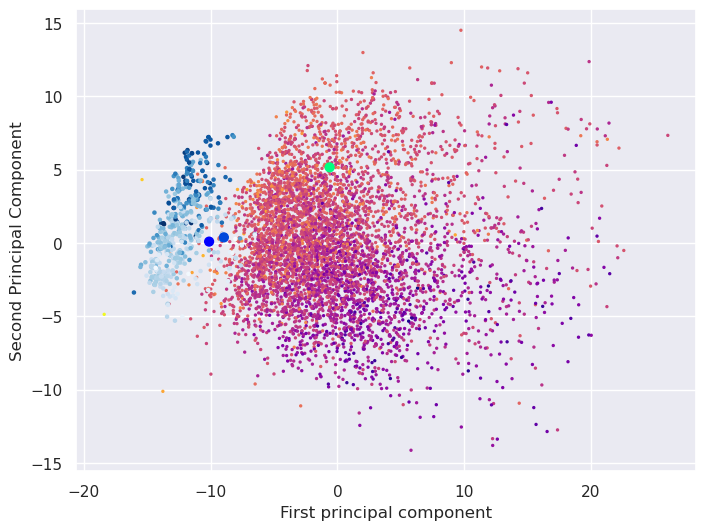

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], s=2, marker='o', c=df1['minimizedAffinity'], cmap='plasma')
plt.scatter(y_pca[:,0],y_pca[:,1], s=5, marker='o', c=df2['minimizedAffinity'], cmap='Blues')
plt.scatter(z_pca[:,0],z_pca[:,1], s=40, marker='o', c=df3['minimizedAffinity'], cmap='winter')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component') 